Used Code

In [ ]:
# import required modules
import numpy as np
import pandas as pd
import cv2
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [3]:
# functions for data loading and preprocessing

# load train data
def load_data(coco, image_folder):
    data_points = []

    img_ids = coco.getImgIds()

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = image_folder + img_info['file_name']

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue

        # Get all annotations for the current image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        for ann in annotations:
            bbox = ann['bbox']
            x_min, y_min, width, height = map(int, bbox)

            cropped_image = image[y_min:y_min + height, x_min:x_min + width]

            category_id = ann['category_id']
            category_label = coco.loadCats([category_id])[0]['name']

            data_points.append((cropped_image, category_label))

    return data_points

# image preprocessing
def preprocess_image(image):

    image = cv2.resize(image, (64, 64))
    features = image.reshape(-1)

    return features

# data preprocessing for train data
def preprocess_data(data, category_map, transform):
  X = []
  y = []

  for image, label in data:
      X.append(transform(image))
      y.append(category_map[label])

  X = np.array(X)
  y = np.array(y)

  return X, y

# load test data
def load_data_test(coco, image_folder):
    data_points = []

    img_ids = coco.getImgIds()

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = image_folder + img_info['file_name']

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue

        # Get all annotations for the current image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        for ann in annotations:
            bbox = ann['bbox']
            x_min, y_min, width, height = map(int, bbox)

            cropped_image = image[y_min:y_min + height, x_min:x_min + width]

            data_points.append(cropped_image)

    return data_points

# data preprocessing for test data
def preprocess_test(data, transform):
  X = []

  for image in data:
      X.append(transform(image))
      
  X = np.array(X)

  return X

In [4]:
# loading and preprocessing train dataset
# load train dataset
train_csv_path = '/Users/GraceKim/Documents/서울대학교/2024_2/기머닝/Project/problem1/train.csv'
annotations_path = '/Users/GraceKim/Documents/서울대학교/2024_2/기머닝/Project/problem1/train/_annotations.coco.json'
train_folder_path = '/Users/GraceKim/Documents/서울대학교/2024_2/기머닝/Project/problem1/train/'

coco = COCO(annotations_path)
data = load_data(coco, train_folder_path)

cropped_image = []
category_label = []

for i in range(len(data)) :
    cropped_image.append(data[i][0])
    category_label.append(data[i][-1])

categories = coco.loadCats(coco.getCatIds())
category_map = {}

for category in categories:
    category_map[category['name']] = category['id']

id_map = {v: k for k, v in category_map.items()}

# preprocessing
X, y = preprocess_data(data, category_map, transform=preprocess_image)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
# loading and preprocessing test dataset
test_csv_path = '/Users/GraceKim/Documents/서울대학교/2024_2/기머닝/Project/problem1/test.csv'
test_annotations_path = '/Users/GraceKim/Documents/서울대학교/2024_2/기머닝/Project/problem1/test/_annotations.coco.json'
test_folder_path = '/Users/GraceKim/Documents/서울대학교/2024_2/기머닝/Project/problem1/test/'

coco_test = COCO(test_annotations_path)
data_test = load_data_test(coco_test, test_folder_path)

X_test = preprocess_test(data_test, transform=preprocess_image)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
def augmentation(X, y, category_label):
    
    indices_class1 = np.where(np.array(category_label) == 1)[0]
    indices_class2 = np.where(np.array(category_label) == 2)[0]
    indices_class3 = np.where(np.array(category_label) == 3)[0]

    X_aug = list(X)
    y_aug = list(y)

    # Augment label 1 (append and flip)
    for idx in indices_class1:
        image = X[idx].reshape(64, 64)

        # original image
        X_aug.append(image.flatten())
        y_aug.append(1)

        # Apply flip and append
        flipped_image = cv2.flip(image, 1)  # Horizontal flip
        X_aug.append(flipped_image.flatten())
        y_aug.append(1)

    # Augment label 2 (apply two different augmentations)
    for idx in indices_class2:
        image = X[idx]

        # flip vertically
        augmentation1 = 'flip1'
        image1 = apply_augmentation(image, augmentation1)
        X_aug.append(image1.flatten())
        y_aug.append(2)

        # flip vertically
        augmentation2 = 'flip1'
        image2 = apply_augmentation(image, augmentation2)
        X_aug.append(image2.flatten())
        y_aug.append(2)

    # Augment label 3 (append twice)
    for idx in indices_class3:
        image = X[idx].reshape(64, 64)

        # original image
        X_aug.append(image.flatten())
        y_aug.append(3)

        X_aug.append(image.flatten())
        y_aug.append(3)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    return X_aug, y_aug


def apply_augmentation(image, augmentation_type):

    image = image.reshape(64, 64)

    if augmentation_type == 'flip1':
        # Vertical flip
        return cv2.flip(image, 0)
    
    elif augmentation_type == 'flip2':
        # Horizontal flip
        return cv2.flip(image, 1) 
    
    elif augmentation_type == 'rotate30':
        # Rotate 30 degrees
        height = 64
        width = 64
        image_center = (width // 2, height // 2)

        rot_mtx = cv2.getRotationMatrix2D(image_center, angle=30, scale=1)
        rot_image = cv2.warpAffine(image, rot_mtx, (width, height))

        return rot_image
        
    elif augmentation_type == 'rotate-30':
        # Rotate -30 degrees
        height = 64
        width = 64
        image_center = (width // 2, height // 2)

        rot_mtx = cv2.getRotationMatrix2D(image_center, angle=-30, scale=1)
        rot_image = cv2.warpAffine(image, rot_mtx, (width, height))
        
        return rot_image

In [8]:
# creating first file - svm.csv

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

svm = SVC(C=7, kernel='rbf',gamma='scale')
svm.fit(X_train,y_train)

X_test = preprocess_test(data_test, transform=preprocess_image)
X_test = scaler.transform(X_test)

y_test = svm.predict(X_test)

sample_submission = pd.read_csv('sample_submission.csv')

for i in range(2323) :
    sample_submission['label'][i] = y_test[i]

sample_submission.to_csv('svm.csv', index=False)

In [10]:
# creating first file - augmentation.csv

X_aug, y_aug = augmentation(X, y, category_label)
X_combined = np.concatenate((X, X_aug), axis=0)
y_combined = np.concatenate((y, y_aug), axis=0)

scaler_aug = StandardScaler()
X_combined = scaler_aug.fit_transform(X_combined)

svm_aug = SVC(kernel='rbf', random_state=42, C=7.75, gamma='scale', class_weight='balanced')
svm_aug.fit(X_combined, y_combined)

# create csv file for submission

X_test = preprocess_test(data_test, transform=preprocess_image)
X_test = scaler_aug.transform(X_test)
y_pred = svm_aug.predict(X_test)

sample_submission = pd.read_csv('sample_submission.csv')

for i in range(2323) :
    sample_submission['label'][i] = y_pred[i]

csv_file_name = 'augmentation.csv'
sample_submission.to_csv(csv_file_name, index=False)

In [17]:
class VotingClassifier:
    def __init__(self, model1, model2): # model1 : svm / model2 : svm_aug7
        self.model1 = model1
        self.model2 = model2

    def predict(self, X):

        y_pred1 = self.model1.predict(X)    # svc w/o augmentation
        y_pred2 = self.model2.predict(X)    # svc w augmentation
        
        y_pred_final = np.zeros(X.shape[0], dtype=int)
        
        for i in range(X.shape[0]):
            if y_pred1[i] == 3:
                y_pred_final[i] = y_pred1[i]

            elif y_pred1[i] == 1 and y_pred2[i] == 2 :
                y_pred_final[i] = y_pred1[i]

            else:
                y_pred_final[i] = y_pred2[i]
        
        return y_pred_final
    

voting = VotingClassifier(model1=svm, model2=svm_aug)
y_pred = voting.predict(X_test)

sample_submission = pd.read_csv('sample_submission.csv')

for i in range(2323) :
    sample_submission['label'][i] = y_pred[i]

csv_file_name = 'problem1_2022_17611.csv'
sample_submission.to_csv(csv_file_name, index=False)


Appendix

In [18]:
# functions for comparing csv files and showing their differences

def csv_comparison(csv1, csv2) :
    csv1 = pd.read_csv(csv1)
    csv2 = pd.read_csv(csv2)

    difference = 0
    different_indices = []

    if len(csv1) == len(csv2) :
        for i in range(len(csv1))  :
            if csv1['label'][i] != csv2['label'][i] :
                difference += 1
                different_indices.append(i)

    return difference, different_indices

def show_differences(csv1,csv2) :

    csv1_df = pd.read_csv(csv1)
    csv2_df = pd.read_csv(csv2)

    num, indices = csv_comparison(csv1, csv2)
    print(csv_comparison(csv1, csv2))

    figures = []

    for idx in indices:
        fig = plt.figure()
        plt.imshow(X_test[idx].reshape(64, 64))
        plt.title(f"Index: {idx}\n{csv1}: {csv1_df['label'][idx]}, {csv2}: {csv2_df['label'][idx]}")
        plt.axis('off')
        figures.append(fig)

        print(f"{csv1} for {idx}: {csv1_df['label'][idx]}")
        print(f"{csv2} for {idx}: {csv2_df['label'][idx]}")
        print('\n')

(21, [513, 623, 633, 675, 938, 953, 988, 1003, 1029, 1061, 1229, 1351, 1368, 1373, 1712, 1791, 2006, 2065, 2257, 2273, 2283])
(21, [513, 623, 633, 675, 938, 953, 988, 1003, 1029, 1061, 1229, 1351, 1368, 1373, 1712, 1791, 2006, 2065, 2257, 2273, 2283])
svm.csv for 513: 1
augmentation.csv for 513: 2


svm.csv for 623: 3
augmentation.csv for 623: 1


svm.csv for 633: 3
augmentation.csv for 633: 1


svm.csv for 675: 2
augmentation.csv for 675: 1


svm.csv for 938: 2
augmentation.csv for 938: 1


svm.csv for 953: 2
augmentation.csv for 953: 1


svm.csv for 988: 2
augmentation.csv for 988: 1


svm.csv for 1003: 2
augmentation.csv for 1003: 1


svm.csv for 1029: 2
augmentation.csv for 1029: 1


svm.csv for 1061: 1
augmentation.csv for 1061: 3


svm.csv for 1229: 2
augmentation.csv for 1229: 1


svm.csv for 1351: 2
augmentation.csv for 1351: 1


svm.csv for 1368: 1
augmentation.csv for 1368: 2


svm.csv for 1373: 1
augmentation.csv for 1373: 2


svm.csv for 1712: 3
augmentation.csv for 1712: 1

/var/folders/6d/z5x25jw536n6s5dh346swc440000gp/T/ipykernel_15325/1488954827.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


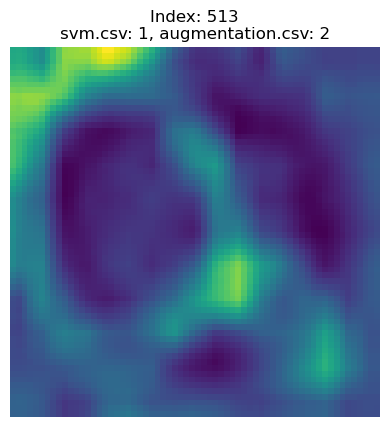

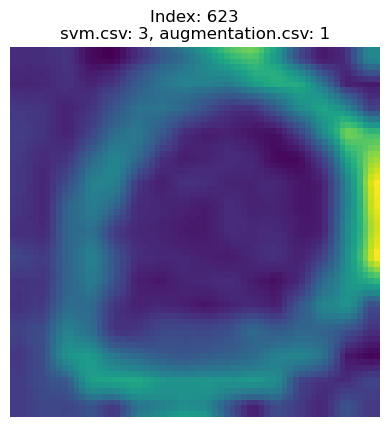

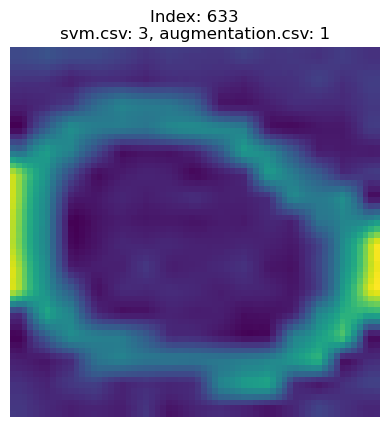

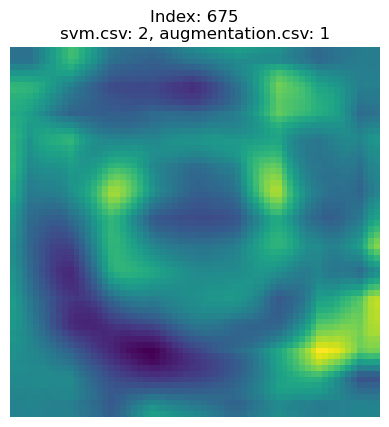

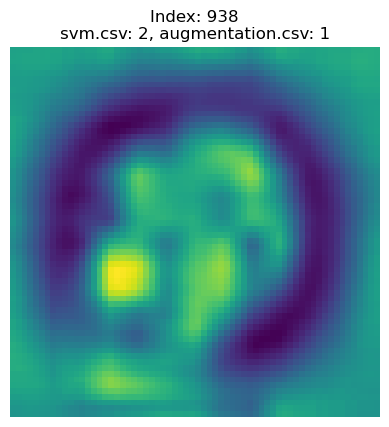

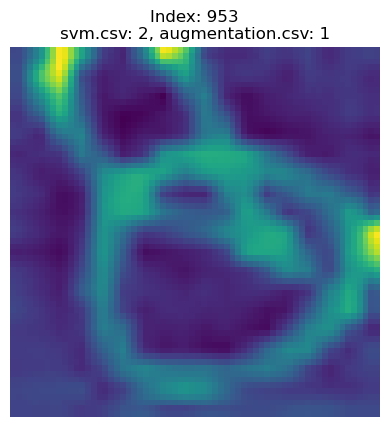

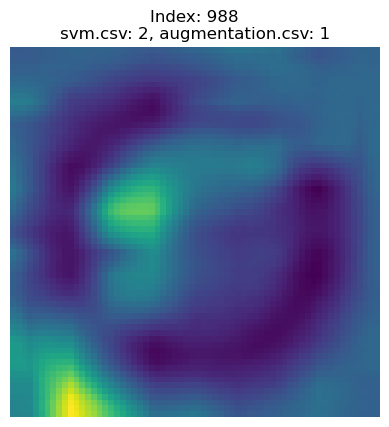

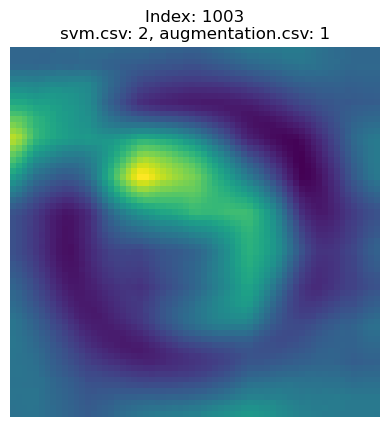

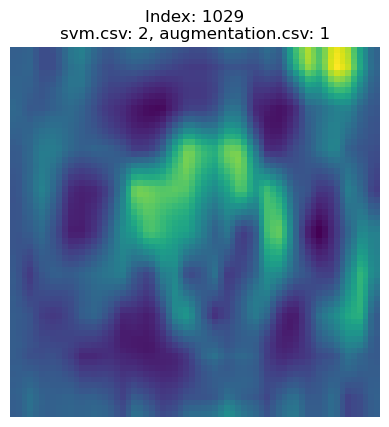

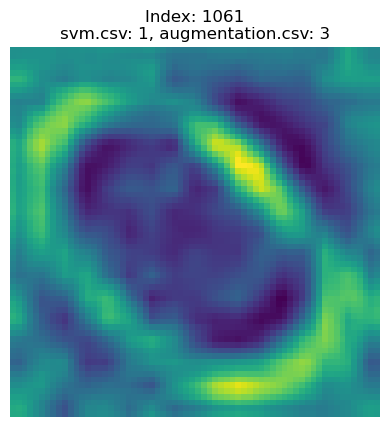

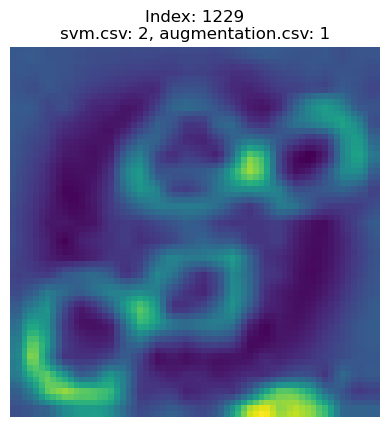

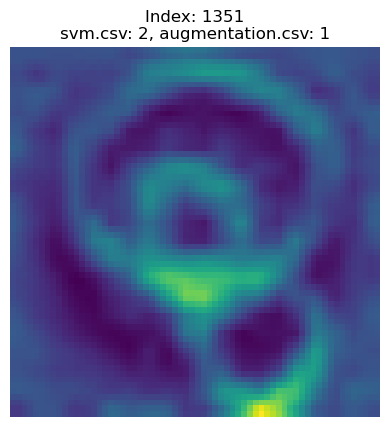

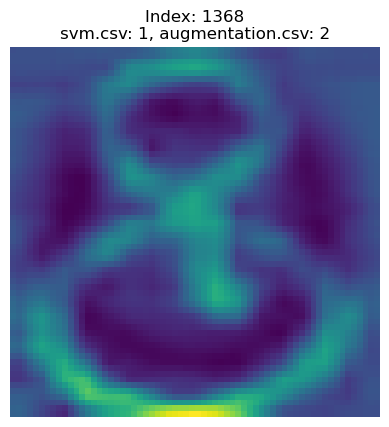

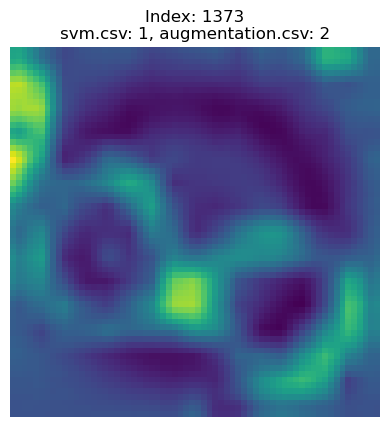

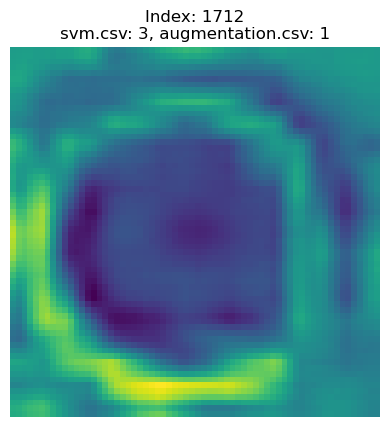

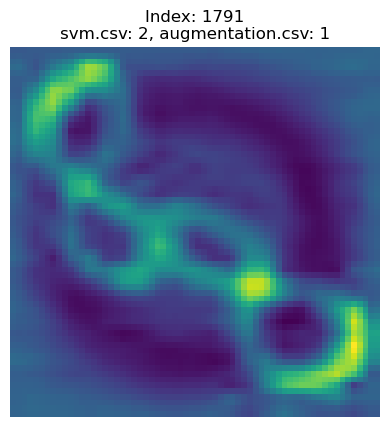

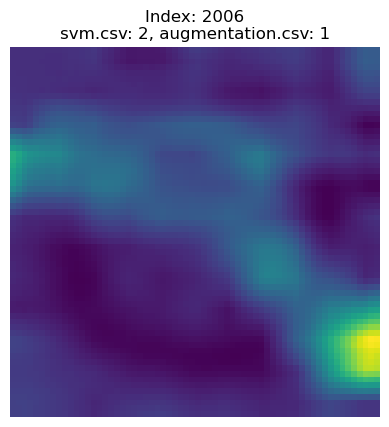

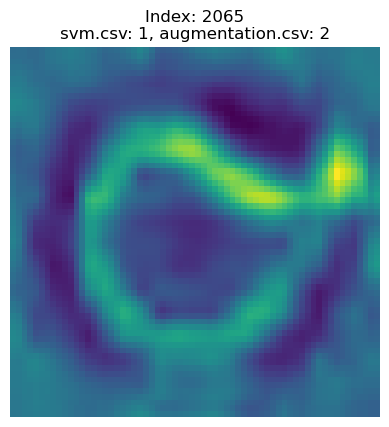

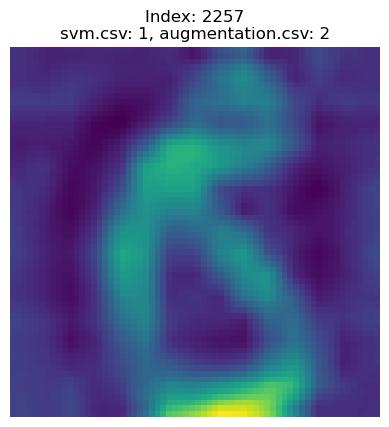

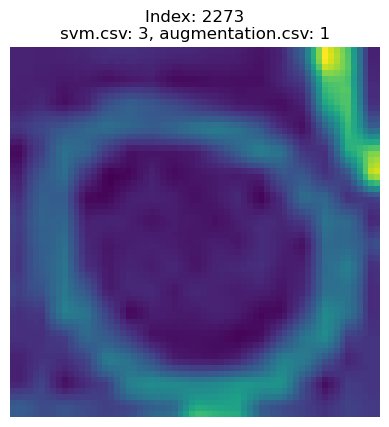

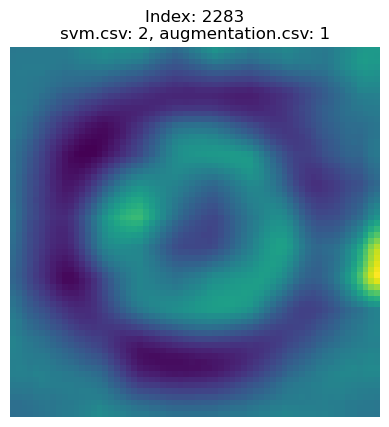

In [22]:
# comparing svm model and augemented model
# by comparison, we can find that svm model detects class3 better, and augmented model detects class2 better

print(csv_comparison('svm.csv','augmentation.csv'))
show_differences('svm.csv','augmentation.csv')

In [20]:
# actual function used for augmentation - commented for convenience
'''
import random

def augmentation(X, y, category_label):
    
    indices_class1 = np.where(np.array(category_label) == 1)[0]
    indices_class2 = np.where(np.array(category_label) == 2)[0]
    indices_class3 = np.where(np.array(category_label) == 3)[0]

    X_aug = list(X)
    y_aug = list(y)

    # Augment label 1 (append and flip)
    for idx in indices_class1:
        image = X[idx].reshape(64, 64)

        # original image
        X_aug.append(image.flatten())
        y_aug.append(1)

        # Apply flip and append
        flipped_image = cv2.flip(image, 1)  # Horizontal flip
        X_aug.append(flipped_image.flatten())
        y_aug.append(1)

    # Augment label 2 (apply two different augmentations)
    for idx in indices_class2:
        image = X[idx]

        # flip vertically
        augmentation1 = random.choice(['flip1', 'flip2', 'rotate30', 'rotate-30'])
        image1 = apply_augmentation(image, augmentation1)
        X_aug.append(image1.flatten())
        y_aug.append(2)

        # flip vertically
        augmentation2 = random.choice(['flip1', 'flip2', 'rotate30', 'rotate-30'])
        image2 = apply_augmentation(image, augmentation2)
        X_aug.append(image2.flatten())
        y_aug.append(2)

    # Augment label 3 (append twice)
    for idx in indices_class3:
        image = X[idx].reshape(64, 64)

        # original image
        X_aug.append(image.flatten())
        y_aug.append(3)

        X_aug.append(image.flatten())
        y_aug.append(3)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    return X_aug, y_aug

def apply_augmentation(image, augmentation_type):

    image = image.reshape(64, 64)

    if augmentation_type == 'flip1':
        # Vertical flip
        return cv2.flip(image, 0)
    
    elif augmentation_type == 'flip2':
        # Horizontal flip
        return cv2.flip(image, 1) 
    
    elif augmentation_type == 'rotate30':
        # Rotate 30 degrees
        height = 64
        width = 64
        image_center = (width // 2, height // 2)

        rot_mtx = cv2.getRotationMatrix2D(image_center, angle=30, scale=1)
        rot_image = cv2.warpAffine(image, rot_mtx, (width, height))

        return rot_image
        
    elif augmentation_type == 'rotate-30':
        # Rotate -30 degrees
        height = 64
        width = 64
        image_center = (width // 2, height // 2)

        rot_mtx = cv2.getRotationMatrix2D(image_center, angle=-30, scale=1)
        rot_image = cv2.warpAffine(image, rot_mtx, (width, height))
        
        return rot_image
'''

"\nimport random\n\ndef augmentation(X, y, category_label):\n    \n    indices_class1 = np.where(np.array(category_label) == 1)[0]\n    indices_class2 = np.where(np.array(category_label) == 2)[0]\n    indices_class3 = np.where(np.array(category_label) == 3)[0]\n\n    X_aug = list(X)\n    y_aug = list(y)\n\n    # Augment label 1 (append and flip)\n    for idx in indices_class1:\n        image = X[idx].reshape(64, 64)\n\n        # original image\n        X_aug.append(image.flatten())\n        y_aug.append(1)\n\n        # Apply flip and append\n        flipped_image = cv2.flip(image, 1)  # Horizontal flip\n        X_aug.append(flipped_image.flatten())\n        y_aug.append(1)\n\n    # Augment label 2 (apply two different augmentations)\n    for idx in indices_class2:\n        image = X[idx]\n\n        # flip vertically\n        augmentation1 = random.choice(['flip1', 'flip2', 'rotate30', 'rotate-30'])\n        image1 = apply_augmentation(image, augmentation1)\n        X_aug.append(image1.

In [ ]:
# GridSearchCV - Used for finding best parameters for SVC model
# Commented for convenience
'''
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

pipeline = Pipeline([
    ('classifier', SVC(random_state=42))
])

param_grid = {
    'classifier__C': [6, 7, 8],
    'classifier__kernel': ['rbf']
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on validation set
y_val_pred = grid_search.best_estimator_.predict(X_val)
report = classification_report(y_val, y_val_pred)
print(report)

'''

In [ ]:
# GridSearchCV - Used for finding best parameters for augmented SVC model
# Commented for convenience
'''
# Model Training - Tuning 2
y_xgboost = y - 1 # ony for XGBoost

# split train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# set pipline and param_grid
pipeline = Pipeline([
    ('classifier', SVC(random_state=42))
])

param_grid = {
    'classifier__C': [7.5, 7.75, 8, 8.5, 9],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale', 0.000125, 0.00015, 0.000100]
}

# grid search
grid_search2 = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)
grid_search2.fit(X_train, y_train)

# best parameters & best sccores
print("best parameters:", grid_search2.best_params_)
print("best score:", grid_search2.best_score_)

# Evaluate on validation set
y_val_pred2 = grid_search2.best_estimator_.predict(X_val)
report2 = classification_report(y_val, y_val_pred2)
print(report2)

'''